# Исследование надежности заемщиков


Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Описание данных

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

## Предобработка данных

In [1]:
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')


In [3]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


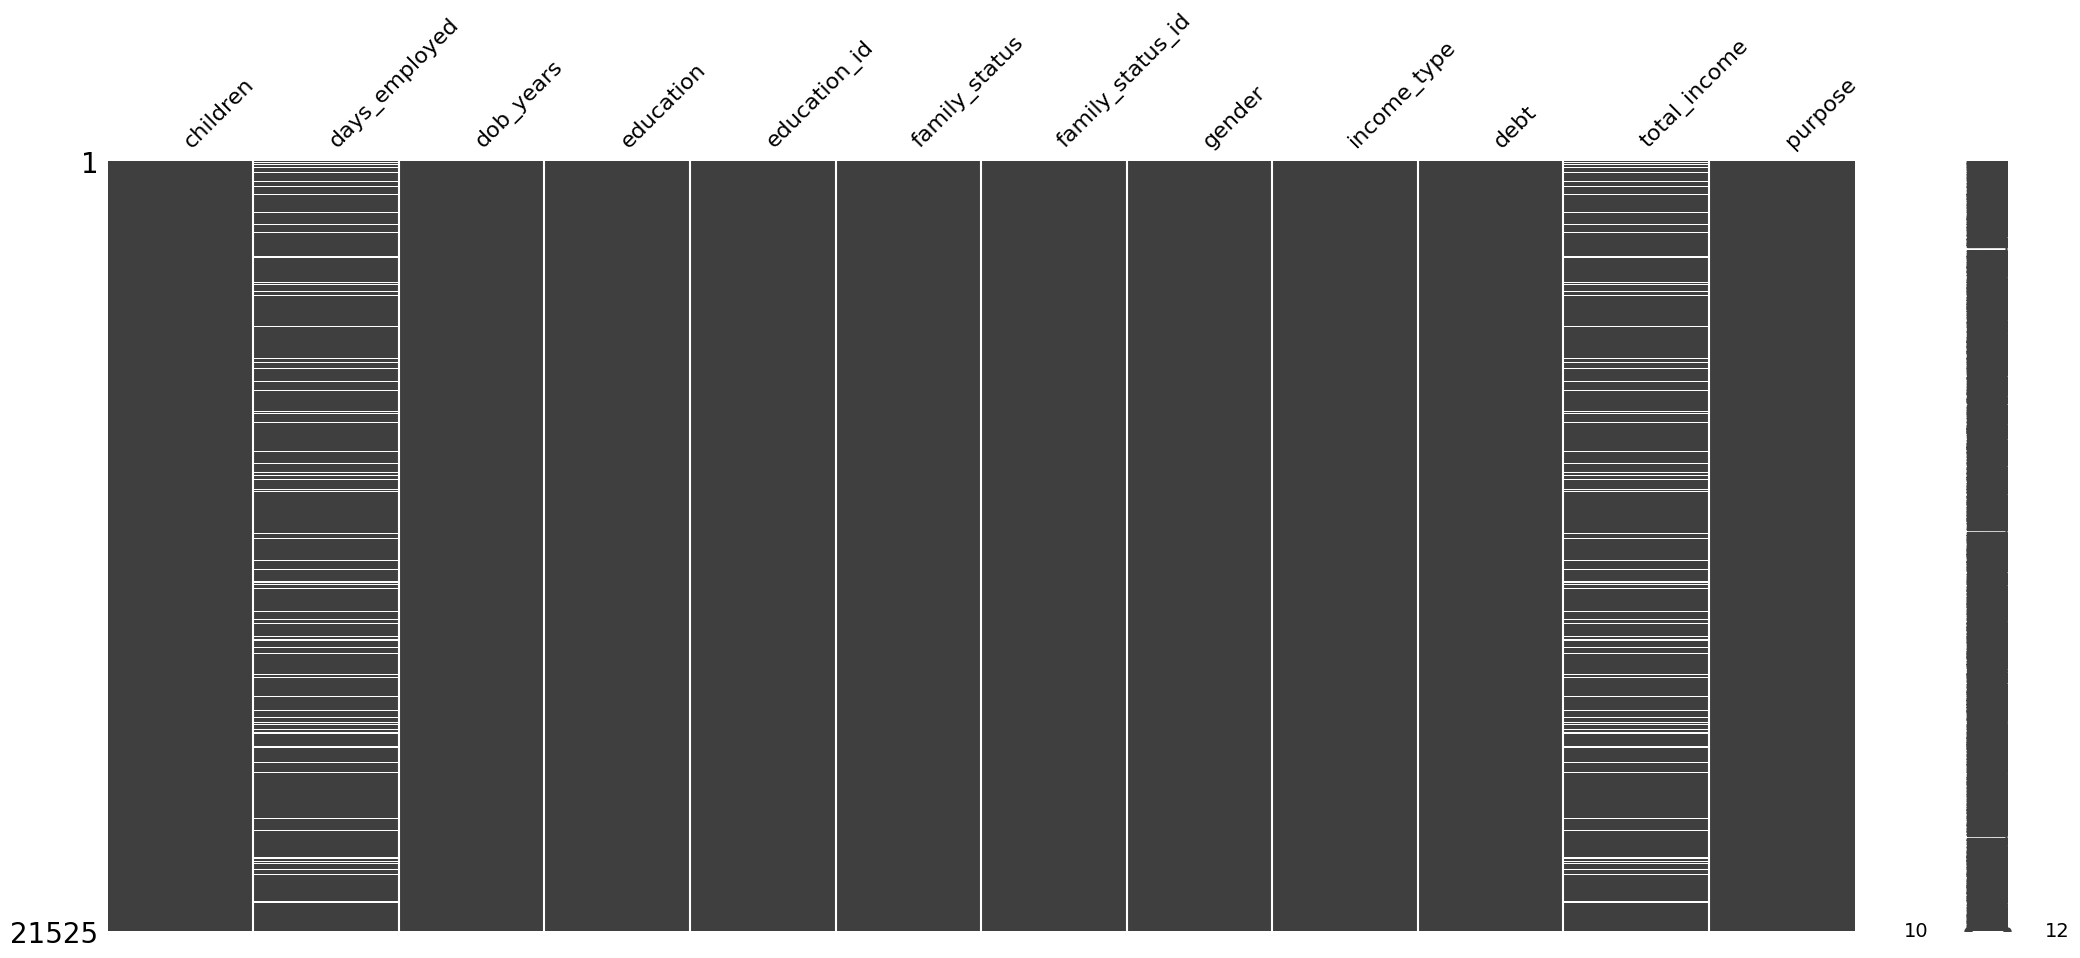

In [5]:
# Визуализация пропусков
msno.matrix(data)
plt.show()

In [6]:
data.isna().sum()

,0
children,0
days_employed,2174
dob_years,0
education,0
education_id,0
family_status,0
family_status_id,0
gender,0
income_type,0
debt,0


В двух столбцах есть пропущенные значения. Один из них — days_employed. Другой столбец с пропущенными значениями — total_income — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполним пропуски в этом столбце медианным значением по каждому типу из столбца income_type.


In [7]:
for t in data['income_type'].unique():
    data.loc[
        (data['income_type'] == t) & (data['total_income'].isna()),
        'total_income'
    ] = data.loc[
        (data['income_type'] == t),
        'total_income'
    ].median()

### Обработка аномалий
в столбце `days_employed` есть отрицательные значения, изменим их на положителные, так как имеет место некорректное занесение данных в таблицу


In [8]:
data['days_employed'] = abs(data['days_employed'])

Для каждого типа занятости выведeм медианное значение трудового стажа days_employed в днях.

In [9]:
data.groupby('income_type')['days_employed'].agg('median')

,days_employed
income_type,
безработный,366413.652744
в декрете,3296.759962
госслужащий,2689.368353
компаньон,1547.382223
пенсионер,365213.306266
предприниматель,520.848083
сотрудник,1574.202821
студент,578.751554


Данные аномально большие в категориях 'безработные' и 'пенсионеры' но скорректировать их сложно. Оставляем без изменений

In [10]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [11]:
t = data[(data['children'] == -1) | (data['children'] == 20)]
len(t)

123

Удалим некорректные значения -1 и 20 , 123 записи

In [12]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data.size

256824

Заполним пропуски в признаке `days_employed` медианным значением по каждой из соответсвующих групп в признаке `income type`

In [13]:
data['days_employed'] = data.groupby('income_type')['days_employed'].transform(
    lambda x: x.fillna(x.median())
)


In [14]:
data.isna().sum()

,0
children,0
days_employed,0
dob_years,0
education,0
education_id,0
family_status,0
family_status_id,0
gender,0
income_type,0
debt,0


In [15]:
# приведем данные с подходящим типам
data['total_income'] = data['total_income'].astype(int)

In [16]:
# обработка неявных дубликатов
data[['education', 'purpose']] = data[['education', 'purpose']].apply(lambda x: x.str.lower())
data.duplicated().sum()

np.int64(71)

In [17]:
data = data.drop_duplicates()

### Категоризация данных и обработка текстовых признаков



На основании диапазонов, указанных ниже, добавим признак столбец total_income_category с категориями:

- 0–30000 — 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'.

In [18]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [19]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

In [20]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

На основе признака данных по целям кредита сформируем новый признак `purpose_category` в который войдут категории:

- 'операции с автомобилем',
- 'операции с недвижимостью',
- 'проведение свадьбы',
- 'получение образования'


In [21]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [22]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследовательский анализ данных

С помощью подготовленных данных ответим на следующие вопросы:

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [23]:
# с помощью mean() узнаем среднее значение заемщиков по каждой группе 'children',
# у которых '1' в графе 'debt',

grouped_by_debt = (data.groupby('children')['debt'].mean() * 100).round(2)

print("Процент должников по каждой группе:")
grouped_by_debt

Процент должников по каждой группе:


,debt
children,
0,7.54
1,9.23
2,9.45
3,8.18
4,9.76
5,0.00


In [24]:
# Создаем копию датасета, что бы не работать с исходным
temp = data.copy()

def que(category):
    data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
    data_temp.columns = ['Всего кредитополучателей', 'Всего должников', 'Доля должников']
    # Оформим таблицу цветным градиентом
    display(data_temp.style.format("{:.3f}").background_gradient(cmap='Blues', axis=0))

que('children')

,Всего кредитополучателей,Всего должников,Доля должников
children,,,
0,14091.000,1063.000,0.075
1,4808.000,444.000,0.092
2,2052.000,194.000,0.095
3,330.000,27.000,0.082
4,41.000,4.000,0.098
5,9.000,0.000,0.000


**Вывод:**  из полученных данных следует, что доля заемщиков без детей, имеющих просрочку по кредиту ниже доли заемщиков, имеющих 1, 2, 3 и 4 ребенка. При этом в данной выборке отсутствуют клиенты с 5 детьми, имеющие задолженность по кредиту, однако нельзя сделать однозначного вывода о наличии взаимосвязи, так как в таблице их доля от общего числа клиентов крайне мала, всего 9 записей из 21331

 ### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [25]:
grouped_by_status = (data.groupby('family_status')['debt'].mean() * 100).round(2)
grouped_by_status

,debt
family_status,
Не женат / не замужем,9.76
в разводе,7.06
вдовец / вдова,6.62
гражданский брак,9.31
женат / замужем,7.56


**Вывод:** Из полученных данных, можно сделать вывод что заемщики с семейным положением *"Не женат / не замужем"* и находящиеся в гражданском браке имеют наибольший процент невозврата кредита в срок, а заемщики из категорий *"вдовец"* и *"в разводе"* наименьший.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [26]:
# Выведем series с числом клиентов по каждой категории . (какой стобец здесь корректнее выводить?)
data_by_income = data.groupby('total_income_category')['debt'].count()
data_by_income

,debt
total_income_category,
A,25
B,5014
C,15921
D,349
E,22


In [27]:
# Выведем series по каждой категории дохода, где в графе debt находится 0, то есть отсуствие задолженности
no_debt = data.loc[data['debt'] == 0, 'total_income_category'].value_counts().sort_index()
no_debt

,count
total_income_category,
A,23
B,4660
C,14568
D,328
E,20


In [28]:
# объединим два series (какой способ лучше использовать?) и добавим 3 столбец , где посчитаем процент возврата в срок
df = pd.DataFrame({'Заемщики по категориям': data_by_income, 'Возвратов в срок': no_debt})
df['Возврат в срок, %'] = (df['Возвратов в срок'] / df ['Заемщики по категориям'] * 100).round(2)
df

,Заемщики по категориям,Возвратов в срок,"Возврат в срок, %"
total_income_category,,,
A,25,23,92.00
B,5014,4660,92.94
C,15921,14568,91.50
D,349,328,93.98
E,22,20,90.91


In [29]:
def categorize_reverse(row):
    #"""
    # Возвращает числовой диапазон дохода в зависимости от категории
    #  """
    letter = row.name

    try:
        if letter == 'A':
            return '1000001 и выше'
        elif letter == 'B':
            return '200001–1000000'
        elif letter == 'C':
            return '50001–200000'
        elif letter == 'D':
            return '30001–50000'
        elif letter == 'E':
            return '0–30000'
    except:
        pass

df['Доход']= df.apply(categorize_reverse,axis=1)
df

,Заемщики по категориям,Возвратов в срок,"Возврат в срок, %",Доход
total_income_category,,,,
A,25,23,92.00,1000001 и выше
B,5014,4660,92.94,200001–1000000
C,15921,14568,91.50,50001–200000
D,349,328,93.98,30001–50000
E,22,20,90.91,0–30000


*Вывод:*
 наименьший показатель возврата кредита в срок имеют заемщики с уровнем дохода 0-30000. При этом наилучший показатель у следующей группы 300001-50000. При этом важно отметить что представленные выборки несбалансированы и для оценки зависимости между уровнем дохода и возвратом кредита в срок следует рассматривать только репрезентативные категории дохода B и С. По этим категориям однозначный вывод о зависимости сделать нельзя, необходимо применить дополнительные исследования.

**Примечание:**
представленные выборки несбалансированы и какой-то вывод можно делать только по двум категориям с достаточным размером выборок. Можно, делать дополнительный анализ, разбив данные на равные выборки методом.

In [30]:
temp = data.copy()
start, stop = 3, 8 # начальное и конечное количество категорий
while start <= stop:
    temp['new_category'] = pd.qcut(temp['total_income'], q=start, precision=0)
    que('new_category')
    start += 1
    ;

/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['coun

,Всего кредитополучателей,Всего должников,Доля должников
new_category,,,
"(20666.0, 119218.0]",7110.000,580.000,0.082
"(119218.0, 172357.0]",7239.000,627.000,0.087
"(172357.0, 2265604.0]",6982.000,525.000,0.075


/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['coun

,Всего кредитополучателей,Всего должников,Доля должников
new_category,,,
"(20666.0, 107507.0]",5333.000,427.000,0.080
"(107507.0, 142594.0]",5450.000,480.000,0.088
"(142594.0, 195842.0]",5216.000,444.000,0.085
"(195842.0, 2265604.0]",5332.000,381.000,0.071


/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['coun

,Всего кредитополучателей,Всего должников,Доля должников
new_category,,,
"(20666.0, 98514.0]",4267.000,344.000,0.081
"(98514.0, 132113.0]",4266.000,358.000,0.084
"(132113.0, 161380.0]",4266.000,373.000,0.087
"(161380.0, 214604.0]",4266.000,358.000,0.084
"(214604.0, 2265604.0]",4266.000,299.000,0.070


/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['coun

,Всего кредитополучателей,Всего должников,Доля должников
new_category,,,
"(20666.0, 92092.0]",3555.000,285.000,0.080
"(92092.0, 119218.0]",3555.000,295.000,0.083
"(119218.0, 142594.0]",3673.000,327.000,0.089
"(142594.0, 172357.0]",3566.000,300.000,0.084
"(172357.0, 228893.0]",3427.000,276.000,0.081
"(228893.0, 2265604.0]",3555.000,249.000,0.070


/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['coun

,Всего кредитополучателей,Всего должников,Доля должников
new_category,,,
"(20666.0, 87287.0]",3048.000,233.000,0.076
"(87287.0, 113563.0]",3047.000,262.000,0.086
"(113563.0, 137465.0]",3047.000,263.000,0.086
"(137465.0, 155314.0]",3047.000,264.000,0.087
"(155314.0, 184554.0]",3047.000,257.000,0.084
"(184554.0, 242009.0]",3047.000,242.000,0.079
"(242009.0, 2265604.0]",3048.000,211.000,0.069


/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['count', 'sum', 'mean'])
/tmp/ipython-input-3984693572.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  data_temp = temp.pivot_table(index=category, values='debt', aggfunc=['coun

,Всего кредитополучателей,Всего должников,Доля должников
new_category,,,
"(20666.0, 83837.0]",2667.000,206.000,0.077
"(83837.0, 107507.0]",2666.000,221.000,0.083
"(107507.0, 127546.0]",2666.000,233.000,0.087
"(127546.0, 142594.0]",2784.000,247.000,0.089
"(142594.0, 166525.0]",2549.000,223.000,0.087
"(166525.0, 195842.0]",2667.000,221.000,0.083
"(195842.0, 254250.0]",2665.000,196.000,0.074
"(254250.0, 2265604.0]",2667.000,185.000,0.069


В ходе разбивки на категории выявили диапазон дохода для самой "опасной"  с точки зрения невозврата кредита категории - доход в диапазоне 127546 - 142594 руб.

по данной категории нужно провести более глубокий анализ чтобы выявить признаки на которые можно опираться помимо дохода


### Как разные цели кредита влияют на его возврат в срок?

In [31]:
grouped_by_purpose = data.groupby('purpose_category')['debt'].agg(['count', 'sum'])
# grouped_by_purpose['debt_part'] = (grouped_by_purpose['sum']/grouped_by_purpose['count'] * 100).round(2)
grouped_by_purpose['debt_part'] = (grouped_by_purpose.iloc[:, 1]/grouped_by_purpose.iloc[:, 0] * 100).round(2)
grouped_by_purpose

,count,sum,debt_part
purpose_category,,,
операции с автомобилем,4279,400,9.35
операции с недвижимостью,10751,780,7.26
получение образования,3988,369,9.25
проведение свадьбы,2313,183,7.91


**Вывод:**  Среди всех целей кредита, наименьший процент невозврата в срок имеют операции с недвижимостью, а наибольший - операции с автомобилем и получение образования

Пропуски данных во время анализа могут возникать по разным причинам, основные из них:

- ошибки ввода данных
- технические сбои
- сокрытие информации
- данные недополучены в результате исследования

Количественные пропуски могут быть разделены на случаные и неслучайные. К случайным относят: ошибки ввода данных, технические сбои и невнимательность при сборе данных. К неслучайным пропускам можно отнести: сокрытие информации и недополучение данных ввиду особенностей исследования. В случае нашего исследовния пропуски в данных обнаруживаются в колонках 'days_employed' и 'total_income' - это трудовой стаж в днях и ежемесячный доход. Эти данные являются важными для банка, так что их отсутсвие скорее является результатом появления случаных пропусков, возможно технического сбоя

# Общий вывод

 Исследование данных о надежности заемщиков банка проводилось на основе таблицы с 21331 записью о заемщиках.
  Проведя первичный анализ и предобработку в таблице были найдены и удалены дубликаты строк, а также строки с аномальными значенями в колонке 'children' которые также были удалены, чтобы не искажать результаты исследования. В ходе исследования было выявлено 2174 пропуска значений 'days_employed' и 'total_income' что соответсвует данным "общий трудовой стаж в днях" и "ежемесяный доход". Строки содержащие пропуски в этих данных нежелательно удалять для исследования, поэтому они были заменены медианными значениями по каждой колонке. Данный метод минимизирует влияние пропусков на результаты исследования.

В соответсвующих разделах исследовательского анализа даны ответы на вопросы:

- Есть ли зависимость между количеством детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

Для исследования мы сгруппировали заемщиков по категориям дохода и целям кредита и исследовали каждую группу чтобы затем сравнить.

**Исследовав зависимость возврата кредита в срок от различных факторов можно сделать выводы:**

1. Количество детей у заемщиков влияет на возврат кредита и заемщики без детей менее склонны к просрочке, чем остальные группы с детьми

2. Семейное положениие заемщиков влияет на возврат кредита, но лучше изучать эти группы совместно с другими признаками, так как разделение по группам не женат/не замужем и в разводе может влиять на итог исследования в зависимости от занесения заемщиков в ту или иную группу

3. Влияние уровня дохода неоднозначно. С одной стороны у заемщиков принадлежащих к категории с минимальным значением дохода самый низкий показатель возврата кредита в срок, и с другой стороны по остальным категориями различия минимальны. Стоит также отметить что в данном исследование выборки неравнозначны в отношении и репрезентативны из них лишь две группы дохода:
50001–200000 — 'C'; 200001–1000000 — 'B'. Количества заемщиков в других группах недостаточно чтобы говорить о наличии взаимосвязи. Предлагается провести подробный анализ группы  **127546 - 142594 руб.**

4. В результате исследования целей кредита разделили на 4 основных категории. Заемщики с целями 'операции с недвижимостью' и 'проведение свадьбы' имеют меньший процент просрочки по кредиту чем заемщики, которые берут кредит на цели: 'операции с автомобилем' и 'получение образования'.

Учитывая результаты исследований выше, можно предположить что идеальными заемщикомами для банка являются лица без детей, которые состоят или состояли в официальном браке, с уровнем дохода от 30000, которые берут кредит для операций с недвижимостью и получения образования.

Для того чтобы результаты исследования были более достоверны, рекомендуется минимизировать пропуски в данных о доходе и трудовом стаже клиентов банка, а также внести больше данных о заемщиках с категориями дохода 'A', 'D', 'E'

## Портрет заемщика

Обобщив результаты исследования, можно составить **портрет идеального заёмщика** по совокупоности признаков:
* нет детей;
* статусы брака: официальный, вдовдствующий или в разводе;
* кредит требуется для операций с недвижимостью или для проведения свадьбы.

При одновременном выволнении вышеназванных критериев шанс возврата становится выше, чем в среднем по всем клиентам.

По такому же принцпипу можно составить **потрет высокорискового заёмщика**:
* больше 1 ребёнка;
* не в браке или в гражданском браке;
* кредит требуется для получения образования или операций с автомобилем.


## Рекомендации по сбору данных

Сделать обязательными поля при заполнении анкеты:
* days_employed
* total_income

Исключить наличие аномалий в столбцах:
* total_income (более 2 миллионов)
* children (значения -1 и 20)

Это позволит провести более качественное исследование.